In [1]:
import PyMoosh as pm
import matplotlib.pyplot as plt
import numpy as np

['/home/denis/Documents/git/PyMoosh/notebooks/In-depth_examples', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/denis/.local/lib/python3.10/site-packages', '/home/denis/Documents/git/PyMoosh', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages/IPython/extensions', '/home/denis/.ipython']


/home/denis/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Simple example

List of materials:
Simple, non dispersive: epsilon= (1+0j)
Database material: ExpData: Water


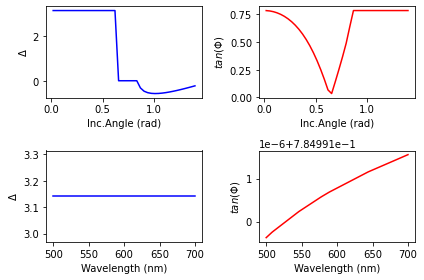

In [2]:

mat = [1.,"Water"]
layers = [1, 0]
structure = [0, 0]

interface = pm.Structure(mat, layers, structure)

wav_list = np.linspace(500, 700, 100)
theta_list = np.linspace(1,80, 40)*np.pi/180

l_delta = np.zeros((len(wav_list), len(theta_list)))
l_phi = np.zeros((len(wav_list), len(theta_list)))
l_rs = np.zeros((len(wav_list), len(theta_list)), dtype=complex)
l_rp = np.zeros((len(wav_list), len(theta_list)), dtype=complex)

for i, wav in enumerate(wav_list):
    for j, theta in enumerate(theta_list):
        r_s, _, _, _ = pm.coefficient(interface, wav, theta, 0)
        r_p, _, _, _ = pm.coefficient(interface, wav, theta, 1)
        
        ellips = r_p/r_s
        l_delta[i,j] = np.angle(ellips)
        l_phi[i,j] = np.arctan(np.abs(ellips))
        l_rs[i,j] = r_s
        l_rp[i,j] = r_p

fig, ax = plt.subplots(2, 2)
ax[0,0].plot(theta_list, l_delta[0], 'b')
ax[0,0].set_ylabel("$\Delta$")
ax[0,0].set_xlabel("Inc.Angle (rad)")

ax[0,1].plot(theta_list, l_phi[0], 'r')
ax[0,1].set_ylabel("$tan(\Phi)$")
ax[0,1].set_xlabel("Inc.Angle (rad)")

ax[1,0].plot(wav_list, l_delta[:,0], 'b')
ax[1,0].set_ylabel("$\Delta$")
ax[1,0].set_xlabel("Wavelength (nm)")

ax[1,1].plot(wav_list, l_phi[:,0], 'r')
ax[1,1].set_ylabel("$tan(\Phi)$")
ax[1,1].set_xlabel("Wavelength (nm)")
plt.tight_layout()
plt.show()

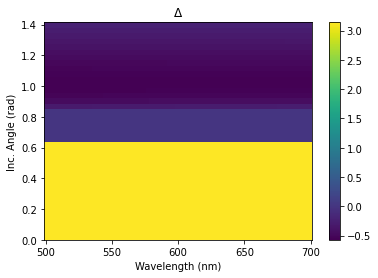

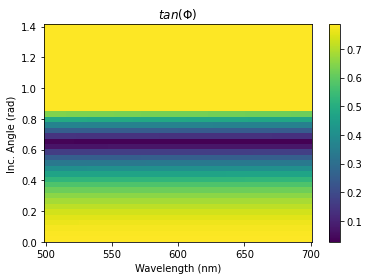

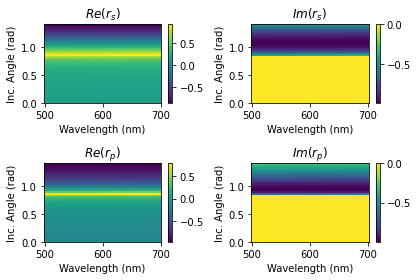

In [3]:
x, y = np.meshgrid(wav_list, theta_list)

plt.pcolormesh(x, y, l_delta.T)
plt.title("$\Delta$")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Inc. Angle (rad)')
plt.colorbar()
plt.show()

plt.pcolormesh(x, y, l_phi.T)
plt.title("$tan(\Phi)$")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Inc. Angle (rad)')
plt.colorbar()
plt.show()


fig, ax = plt.subplots(2, 2)
p = ax[0,0].pcolormesh(x, y, np.real(l_rs.T))
ax[0,0].set_title("$Re(r_s)$")
ax[0,0].set_xlabel('Wavelength (nm)')
ax[0,0].set_ylabel('Inc. Angle (rad)')
plt.colorbar(p, ax=ax[0,0])

p = ax[1,0].pcolormesh(x, y, np.real(l_rp.T))
ax[1,0].set_title("$Re(r_p)$")
ax[1,0].set_xlabel('Wavelength (nm)')
ax[1,0].set_ylabel('Inc. Angle (rad)')
plt.colorbar(p, ax=ax[1,0])

p = ax[0,1].pcolormesh(x, y, np.imag(l_rs.T))
ax[0,1].set_title("$Im(r_s)$")
ax[0,1].set_xlabel('Wavelength (nm)')
ax[0,1].set_ylabel('Inc. Angle (rad)')
plt.colorbar(p, ax=ax[0,1])

p = ax[1,1].pcolormesh(x, y, np.imag(l_rp.T))
ax[1,1].set_title("$Im(r_p)$")
ax[1,1].set_xlabel('Wavelength (nm)')
ax[1,1].set_ylabel('Inc. Angle (rad)')
plt.colorbar(p, ax=ax[1,1])
plt.tight_layout()
plt.show()

In [4]:
nb_layers = 1

min_ind = 1.4
max_ind = 2.5
min_th = 50
max_th = 200
from PyMoosh.alt_methods import coefficient_A


mat = [1.] + [np.random.random()*(max_ind-min_ind) + min_ind for _ in range(nb_layers)] + ["Gold"]
layers = [i for i in range(nb_layers+2)]
structure = [0] + [np.random.random()*(max_th-min_th) + min_th for _ in range(nb_layers)] + [0]


angle = 40*np.pi/180
wav_list = np.linspace(400, 600, 100)

def ref_structure(mat, layers, structure, wav_list, angle):
    struct = pm.Structure(mat, layers, structure)
    ellips = np.zeros(len(wav_list), dtype=complex)
    for i, wav in enumerate(wav_list):
        r_s, _, _, _ = pm.coefficient(struct, wav, angle, 0)
        r_p, _, _, _ = pm.coefficient(struct, wav, angle, 1)
        
        ellips[i] = r_p/r_s
    return ellips, struct

ref_ellips, ellips_structure = ref_structure(mat, layers, structure, wav_list, angle)

def cost_ellipso(X, ref_ellips=ref_ellips, wav_list=wav_list, angle=angle, nb_layers=nb_layers):
    mat = [1.] + [x for x in X[:nb_layers]] + ["Gold"]
    layers = [i for i in range(nb_layers+2)]
    structure = [0] + [x for x in X[nb_layers:]] + [0]
    
    ellips = np.zeros(len(wav_list), dtype=complex)
    interface = pm.Structure(mat, layers, structure, verbose=False)
    for i, wav in enumerate(wav_list):
        r_s, _, _, _ = coefficient_A(interface, wav, angle, 0)
        r_p, _, _, _ = coefficient_A(interface, wav, angle, 1)
        
        ellips[i] = r_p/r_s
    
    return np.sum(np.abs(ellips - ref_ellips))/len(wav_list)
    


List of materials:
Simple, non dispersive: epsilon= (1+0j)
Simple, non dispersive: epsilon= (1.5384910988236997+0j)
Database material: BrendelBormann model: Gold


In [5]:

budget = 2500

X_min = np.array([min_ind] * (nb_layers) +  [min_th] * (nb_layers))
X_max = np.array([max_ind] * (nb_layers) +  [max_th] * (nb_layers))

nb_runs = 10

convs = []
bests = []
scores = []
for i in range(nb_runs):
    best, convergence = pm.differential_evolution(cost_ellipso, budget, X_min, X_max)
    bests.append(best)
    convs.append(convergence)
    scores.append(convergence[-1])
    print(f"Run {i+1} out of {nb_runs} done")

order = np.argsort(scores)
print(order)
best = bests[order[0]]


worst = bests[order[-1]]

Run 1 out of 10 done
Run 2 out of 10 done
Run 3 out of 10 done
Run 4 out of 10 done
Run 5 out of 10 done
Run 6 out of 10 done
Run 7 out of 10 done
Run 8 out of 10 done
Run 9 out of 10 done
Run 10 out of 10 done
[8 1 0 5 6 2 4 3 7 9]


List of materials:
Simple, non dispersive: epsilon= (1+0j)
Simple, non dispersive: epsilon= (1.5384902795994477+0j)
Database material: BrendelBormann model: Gold


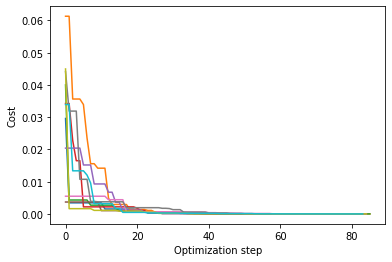

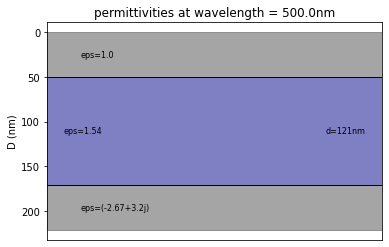

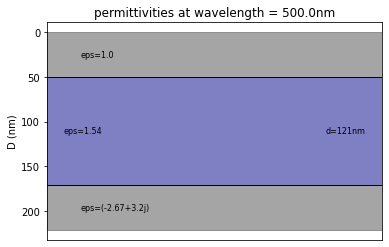

[  1.53849028 121.41454006]
[  1.53848731 121.41547282]
[(1+0j), (1.5384902795994477+0j), (-2.669691056478235+3.1987286903503365j)]
[50, 121.41454006295783, 50]
[(1+0j), (1.5384910988236997+0j), (-2.669691056478235+3.1987286903503365j)]
[50, 121.41446801360232, 50]


In [6]:

mat = [1.] + [x for x in best[:nb_layers]] + ["Gold"]
layers = [i for i in range(nb_layers+2)]
structure = [0] + [x for x in best[nb_layers:]] + [0]
best_struct = pm.Structure(mat, layers, structure)

for i in range(nb_runs):
    plt.plot(convs[i])
plt.xlabel("Optimization step")
plt.ylabel("Cost")
plt.show()


ellips_structure.plot_stack()
best_struct.plot_stack()


print(best)
print(worst)
print([best_struct.materials[i].get_permittivity(500) for i in best_struct.layer_type])
print(best_struct.thickness)
print([ellips_structure.materials[i].get_permittivity(500) for i in ellips_structure.layer_type])
print(ellips_structure.thickness)